/Users/cag/Dropbox/0_Research/0_githubs/ms_recovery/analysis/5_recovery


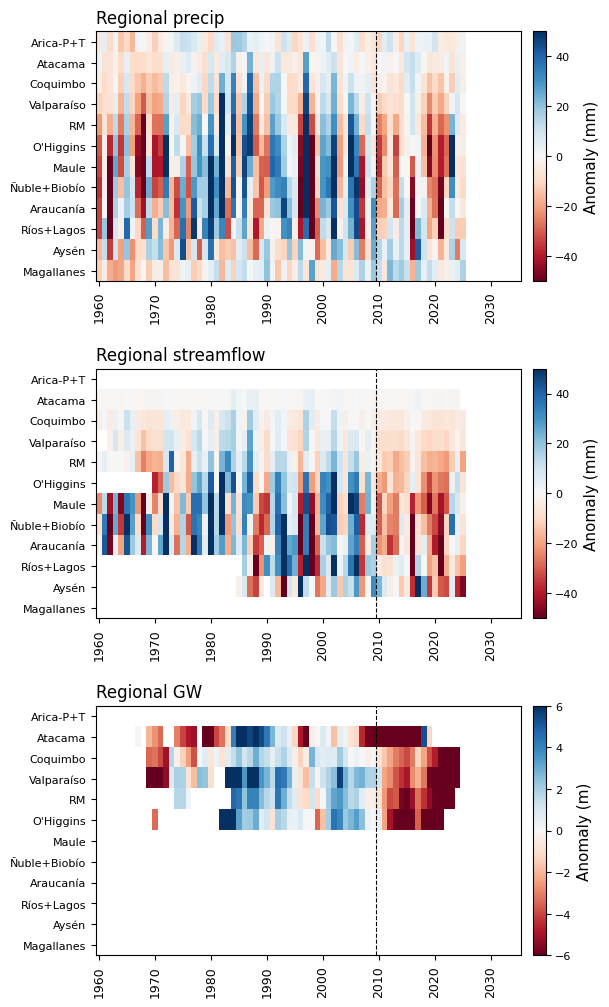

In [43]:
import os
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import TwoSlopeNorm


# run once near the top of the notebook
os.chdir(Path("/Users/cag/Dropbox/0_Research/0_githubs/ms_recovery/analysis/5_recovery"))
print(os.getcwd())
# -------------------- Paths & params --------------------
data_dir = '../../data'
ms_data_dir = f'{data_dir}/ms_data'
camels_dir = f'{data_dir}/camels'

out_figs = 'figs_regional_recovery'
os.makedirs(out_figs, exist_ok=True)

obs_min = 100        # min monthly observations required per well/station overall
n_well_means = 5     # min # wells/stations required per group-year to compute the annual mean

# === Load previous results (to filter data)===
df_r2 = pd.read_csv('../4_GW_Q_memory/csv/gw_memory.csv', dtype={'well_id': str})
eligible_wells = df_r2['well_id'].unique()

df_r2_q = pd.read_csv('../4_GW_Q_memory/csv/q_memory.csv', dtype={'gauge_id': str})
eligible_gauges = df_r2_q['gauge_id'].unique()

# -------------------- Region mapping (your rule) --------------------
REGION_NAME_ORDER = [
    'Arica-P+T',
    'Antofagasta',
    'Atacama',
    'Coquimbo',
    'Valparaíso',
    'RM',
    "O'Higgins",
    'Maule',
    'Ñuble+Biobío',
    'Araucanía',
    'Ríos+Lagos',
    'Aysén',
    'Magallanes'
]
REGION_SORT_ORDER = {name: idx for idx, name in enumerate(REGION_NAME_ORDER)}
REGION_CODE_TO_LABEL = {
    1: 'Arica-P+T',
    2: 'Antofagasta',
    3: 'Atacama',
    4: 'Coquimbo',
    5: 'Valparaíso',
    6: "O'Higgins",
    7: 'Maule',
    8: 'Ñuble+Biobío',
    9: 'Araucanía',
    10: 'Ríos+Lagos',
    11: 'Aysén',
    12: 'Magallanes',
    13: 'RM',
}

def sort_regions(region_iterable):
    unique = list(dict.fromkeys(region_iterable))
    return sorted(unique, key=lambda name: REGION_SORT_ORDER.get(name, float('inf')))


def extract_region(code):
    s = str(code)
    if not s:
        raise ValueError('Empty code')
    digits = ''.join(ch for ch in s if ch.isdigit())
    if not digits:
        raise ValueError(f'Cannot parse region code from {code!r}')
    if len(digits) >= 8:
        prefix = int(digits[:2])
    elif digits[0] == '5' and len(digits) >= 2:
        prefix = int(digits[:2])
    else:
        prefix = int(digits[0])
    if 51 <= prefix <= 56:
        return 'Valparaíso'
    if prefix == 57:
        return 'RM'
    label = REGION_CODE_TO_LABEL.get(prefix)
    if label is not None:
        return label
    return str(prefix)


def map_regions(columns):
    regions = {}
    for c in columns:
        try:
            regions[c] = extract_region(c)
        except Exception:
            regions[c] = np.nan
    regions = {k: v for k, v in regions.items() if pd.notna(v)}
    return regions

# -------------------- Load monthly anomalies (GW & PR tied to wells) --------------------
gw_abs_all = pd.read_csv(f'{ms_data_dir}/wells_gw.csv', parse_dates=['date']).set_index('date')[eligible_wells]
gw_climatology = gw_abs_all.groupby(gw_abs_all.index.month).transform('mean')
gw_an_all = gw_abs_all - gw_climatology
gw_m = gw_an_all

# -------------------- Filter wells by GW obs count (overall) --------------------
gw_counts = gw_an_all.notna().sum(axis=0)
keep_wells = gw_counts[gw_counts >= obs_min].index.tolist()
if not keep_wells:
    raise ValueError("No wells meet the obs_min criterion.")

# -------------------- STREAMFLOW (Q): load anomalies, or compute if needed --------------------
q_all = pd.read_csv(f'{camels_dir}/camels_q_mm.csv', parse_dates=['date']).set_index('date')[list(eligible_gauges)]
q_climatology = q_all.groupby(q_all.index.month).transform('mean')
q_an_all = q_all - q_climatology

pr_all_stream = pd.read_csv(f'{camels_dir}/camels_pr_mm.csv', parse_dates=['date']).set_index('date')[list(eligible_gauges)]
pr_climatology_stream = pr_all_stream.groupby(pr_all_stream.index.month).transform('mean')
pr_an_all = pr_all_stream - pr_climatology_stream

# Filter streamflow stations by obs_min
q_counts = q_an_all.notna().sum(axis=0)
keep_stations = q_counts[q_counts >= obs_min].index.tolist()
if not keep_stations:
    raise ValueError("No streamflow stations meet the obs_min criterion.")
q_m = q_an_all[keep_stations]
pr_m = pr_an_all[keep_stations]

# -------------------- Monthly → Annual (mean over months) --------------------
gw_y = gw_m.resample('YE-DEC').mean()
pr_y = pr_m.resample('YE-DEC').mean()
q_y  = q_m.resample('YE-DEC').mean()

for df in (gw_y, pr_y, q_y):
    df.index = df.index.year

full_years = np.arange(1960, 2036)
gw_y = gw_y.reindex(full_years)
pr_y = pr_y.reindex(full_years)
q_y = q_y.reindex(full_years)

# -------------------- Region maps per dataset (YOUR RULE) --------------------
gw_regions = map_regions(gw_y.columns)
pr_regions = map_regions(pr_y.columns)
q_regions  = map_regions(q_y.columns)

# restrict dfs to columns that mapped successfully
gw_y = gw_y[list(gw_regions.keys())]
pr_y = pr_y[list(pr_regions.keys())]
q_y  = q_y[list(q_regions.keys())]

# -------------------- Assign region to columns and compute group means with thresholds --------------------
def groupmean_with_min_count(df_yearly, col2region, min_count, apply_threshold=True):
    df_yearly.columns = pd.MultiIndex.from_tuples([(col2region[c], c) for c in df_yearly.columns],
                                                  names=['region', 'id'])
    counts = df_yearly.T.groupby(level='region').count().T
    means = df_yearly.T.groupby(level='region').mean().T
    if apply_threshold:
        means = means.where(counts >= min_count)
    means = means.reindex(columns=sort_regions(means.columns))
    return means, counts


gw_grp, gw_cnt = groupmean_with_min_count(gw_y, gw_regions, n_well_means, apply_threshold=True)
pr_grp, pr_cnt = groupmean_with_min_count(pr_y, pr_regions, n_well_means, apply_threshold=False)
q_grp,  q_cnt  = groupmean_with_min_count(q_y,  q_regions,  n_well_means, apply_threshold=True)

# -------------------- Harmonize region set and build matrices --------------------
regions_all = sort_regions(set(pr_grp.columns).union(q_grp.columns))

gw_grp = gw_grp.reindex(columns=regions_all)
pr_grp = pr_grp.reindex(columns=regions_all)
q_grp  = q_grp.reindex(columns=regions_all)

region_labels = [str(r) for r in regions_all]

def to_matrix(df_grp, region_order):
    if df_grp.empty:
        return np.empty((len(region_order), 0)), np.array([])
    df_ord = df_grp.reindex(columns=region_order)
    return df_ord.values.T, df_ord.index.values

gw_mat, years_gw = to_matrix(gw_grp, regions_all)
pr_mat, years_pr = to_matrix(pr_grp, regions_all)
q_mat,  years_q  = to_matrix(q_grp,  regions_all)


def decadal_xticks(years):
    if years is None or len(years) == 0:
        return []
    years = np.unique(np.sort(years))
    start = (years.min() // 10) * 10
    end = (years.max() // 10) * 10
    decades = np.arange(start, end + 10, 10)
    decades = decades[(decades >= years.min()) & (decades <= years.max())]
    if decades.size == 0:
        return years
    return decades

# -------------------- Color scaling --------------------
pq_norm = TwoSlopeNorm(vmin=-50, vcenter=0.0, vmax=50)
gw_norm = TwoSlopeNorm(vmin=-6, vcenter=0.0, vmax=6)

# -------------------- Plot (3×1, colorbars at right, larger) --------------------
fig, (ax_pr, ax_q, ax_gw) = plt.subplots(3, 1, figsize=(6,12), constrained_layout=False, sharex=False, sharey=True)
fig.subplots_adjust(hspace=0.35)

cmap='RdBu'
if pr_mat.size:
    im_pr = ax_pr.imshow(
        pr_mat, aspect='auto', interpolation='nearest', cmap=cmap, norm=pq_norm,
        extent=[years_pr.min() - 0.5 if len(years_pr) else -0.5,
                years_pr.max() + 0.5 if len(years_pr) else 0.5,
                len(region_labels) - 0.5, -0.5]
    )
    ax_pr.set_title('Regional precip', loc='left')
    ax_pr.set_yticks(np.arange(len(region_labels)))
    ax_pr.set_yticklabels(region_labels, fontsize=8)
    xt = decadal_xticks(years_pr)
    ax_pr.set_xticks(xt)
    ax_pr.set_xticklabels(xt, rotation=90, ha='center', fontsize=9)
    cb_pr = fig.colorbar(im_pr, ax=ax_pr, orientation='vertical', pad=0.025, fraction=0.06)
    cb_pr.set_label('Anomaly (mm)', fontsize=11)
    cb_pr.ax.tick_params(labelsize=8)
    ax_pr.axvline(2009.5, color='black', linestyle='--', linewidth=.8)
else:
    ax_pr.text(0.5, 0.5, 'No PR data', ha='center', va='center'); ax_pr.axis('off')

if q_mat.size:
    im_q = ax_q.imshow(
        q_mat, aspect='auto', interpolation='nearest', cmap=cmap, norm=pq_norm,
        extent=[years_q.min() - 0.5 if len(years_q) else -0.5,
                years_q.max() + 0.5 if len(years_q) else 0.5,
                len(region_labels) - 0.5, -0.5]
    )
    ax_q.set_title('Regional streamflow', loc='left')
    ax_q.set_yticks(np.arange(len(region_labels)))
    ax_q.set_yticklabels(region_labels, fontsize=8)
    xt = decadal_xticks(years_q)
    ax_q.set_xticks(xt)
    ax_q.set_xticklabels(xt, rotation=90, ha='center', fontsize=9)
    cb_q = fig.colorbar(im_q, ax=ax_q, orientation='vertical', pad=0.025, fraction=0.06)
    cb_q.set_label('Anomaly (mm)', fontsize=11)
    cb_q.ax.tick_params(labelsize=8)
    ax_q.axvline(2009.5, color='black', linestyle='--', linewidth=.8)
else:
    ax_q.text(0.5, 0.5, 'No Q data', ha='center', va='center'); ax_q.axis('off')

if gw_mat.size:
    im_gw = ax_gw.imshow(
        gw_mat, aspect='auto', interpolation='nearest', cmap=cmap, norm=gw_norm,
        extent=[years_gw.min() - 0.5 if len(years_gw) else -0.5,
                years_gw.max() + 0.5 if len(years_gw) else 0.5,
                len(region_labels) - 0.5, -0.5]
    )
    ax_gw.set_title('Regional GW', loc='left')
    ax_gw.set_yticks(np.arange(len(region_labels)))
    ax_gw.set_yticklabels(region_labels, fontsize=8)
    xt = decadal_xticks(years_gw)
    ax_gw.set_xticks(xt)
    ax_gw.set_xticklabels(xt, rotation=90, ha='center', fontsize=9)
    cb_gw = fig.colorbar(im_gw, ax=ax_gw, orientation='vertical', pad=0.025, fraction=0.06)
    cb_gw.set_label('Anomaly (m)', fontsize=11)
    cb_gw.ax.tick_params(labelsize=8)
    ax_gw.axvline(2009.5, color='black', linestyle='--', linewidth=.8)
else:
    ax_gw.text(0.5, 0.5, 'No GW data', ha='center', va='center'); ax_gw.axis('off')

plt.show()


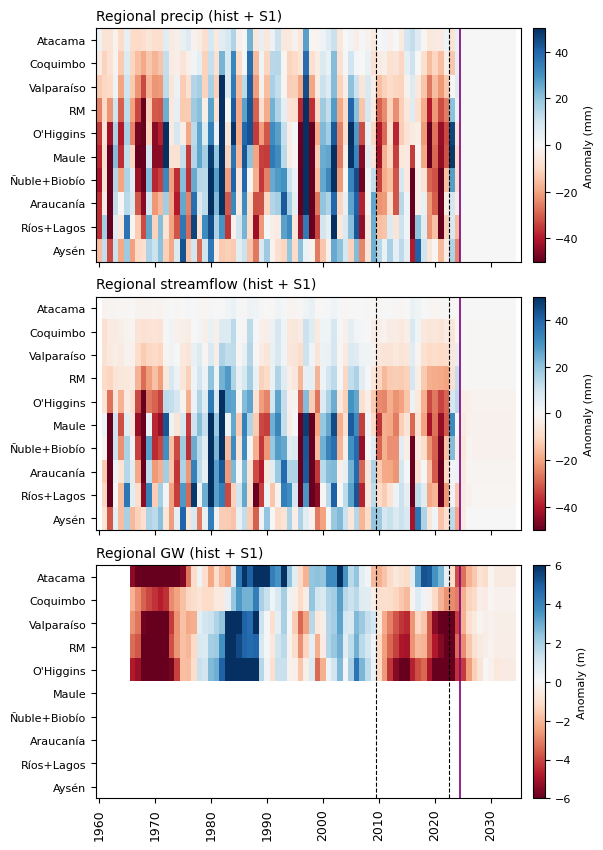

In [46]:
# -------------------- Simulated scenario 1 heatmaps --------------------
sim_csv_dir = Path('csv')
df_r2 = pd.read_csv('../4_GW_Q_memory/csv/gw_memory.csv', dtype={'well_id': str})
eligible_wells = df_r2['well_id'].unique()
df_r2_q = pd.read_csv('../4_GW_Q_memory/csv/q_memory.csv', dtype={'gauge_id': str})
eligible_gauges = df_r2_q['gauge_id'].unique()

cutoff_date = pd.Timestamp('2009-12-31')

def load_hist_plus_future(prefix, variants=None):
    def _load_single(variant=None):
        variant_suffix = f'_{variant}' if variant else ''
        hist_path = sim_csv_dir / f"{prefix}_hist{variant_suffix}.csv"
        sce_path = sim_csv_dir / f"{prefix}_sce1{variant_suffix}.csv"
        hist = pd.read_csv(hist_path, parse_dates=['date']).set_index('date')
        future = pd.read_csv(sce_path, parse_dates=['date']).set_index('date')
        combined = pd.concat([hist, future]).sort_index()
        combined = combined[~combined.index.duplicated(keep='first')]
        baseline = combined.loc[:cutoff_date]
        monthly_mean = baseline.groupby(baseline.index.month).mean()
        monthly_mean = monthly_mean.reindex(range(1, 13))
        month_idx = combined.index.month
        offsets = monthly_mean.take(month_idx - 1, axis=0)
        offsets.index = combined.index
        anomalies = combined - offsets
        if prefix == 'gw_sim':
            anomalies = anomalies.loc[:, anomalies.columns.intersection(eligible_wells)]
        elif prefix in {'q_sim', 'p_sim'}:
            anomalies = anomalies.loc[:, anomalies.columns.intersection(eligible_gauges)]
        return anomalies.dropna(axis=1, how='all')

    if variants is None:
        return _load_single()
    if isinstance(variants, (list, tuple, set)):
        return {variant: _load_single(variant) for variant in variants}
    return _load_single(variants)


p_sim_monthly_data = load_hist_plus_future('p_sim', variants=('basin', 'well'))
p_sim_monthly_basin = p_sim_monthly_data['basin']
p_sim_monthly_well = p_sim_monthly_data['well']

q_sim_monthly = load_hist_plus_future('q_sim')
gw_sim_monthly = load_hist_plus_future('gw_sim')
p_sim_y_data = {key: df.resample('YE-DEC').mean() for key, df in p_sim_monthly_data.items()}

p_sim_y_basin = p_sim_y_data['basin']
p_sim_y_well = p_sim_y_data['well']

q_sim_y = q_sim_monthly.resample('YE-DEC').mean()
gw_sim_y = gw_sim_monthly.resample('YE-DEC').mean()

for df in list(p_sim_y_data.values()) + [q_sim_y, gw_sim_y]:
    df.index = df.index.year

p_sim_y = p_sim_y_basin
full_years_sim = np.arange(1960, 2036)
p_sim_y = p_sim_y.reindex(full_years_sim)
p_sim_y_well = p_sim_y_well.reindex(full_years_sim)
q_sim_y = q_sim_y.reindex(full_years_sim)
gw_sim_y = gw_sim_y.reindex(full_years_sim)

p_sim_regions = map_regions(p_sim_y.columns)
p_sim_regions_well = map_regions(p_sim_y_well.columns)
q_sim_regions = map_regions(q_sim_y.columns)
gw_sim_regions = map_regions(gw_sim_y.columns)

p_sim_y = p_sim_y[list(p_sim_regions.keys())]
p_sim_y_well = p_sim_y_well[list(p_sim_regions_well.keys())]
q_sim_y = q_sim_y[list(q_sim_regions.keys())]
gw_sim_y = gw_sim_y[list(gw_sim_regions.keys())]

p_sim_grp_basin, _ = groupmean_with_min_count(p_sim_y.copy(), p_sim_regions, n_well_means)
p_sim_grp_well, _ = groupmean_with_min_count(p_sim_y_well.copy(), p_sim_regions_well, n_well_means)
p_sim_grp = p_sim_grp_basin.combine_first(p_sim_grp_well)
q_sim_grp, _ = groupmean_with_min_count(q_sim_y.copy(), q_sim_regions, n_well_means)
gw_sim_grp, _ = groupmean_with_min_count(gw_sim_y.copy(), gw_sim_regions, n_well_means)

regions_sim_all = sort_regions(set(regions_all).union(p_sim_grp.columns).union(q_sim_grp.columns).union(gw_sim_grp.columns))

p_sim_grp = p_sim_grp.reindex(columns=regions_sim_all)
p_sim_grp_well = p_sim_grp_well.reindex(columns=regions_sim_all)
q_sim_grp = q_sim_grp.reindex(columns=regions_sim_all)
gw_sim_grp = gw_sim_grp.reindex(columns=regions_sim_all)

allowed_regions_sim = [
    'Atacama',
    'Coquimbo',
    'Valparaíso',
    'RM',
    "O'Higgins",
    'Maule',
    'Ñuble+Biobío',
    'Araucanía',
    'Ríos+Lagos',
    'Aysén',
]

region_labels_sim = allowed_regions_sim

p_sim_mat, years_p_sim = to_matrix(p_sim_grp.reindex(columns=allowed_regions_sim), allowed_regions_sim)
q_sim_mat, years_q_sim = to_matrix(q_sim_grp.reindex(columns=allowed_regions_sim), allowed_regions_sim)
gw_sim_mat, years_gw_sim = to_matrix(gw_sim_grp.reindex(columns=allowed_regions_sim), allowed_regions_sim)

fig_sim, (ax_p_sim, ax_q_sim, ax_gw_sim) = plt.subplots(3, 1, figsize=(6, 10), constrained_layout=False, sharex=False, sharey=True)
fig_sim.subplots_adjust(hspace=0.15)

im_p_sim = ax_p_sim.imshow(
    p_sim_mat, aspect='auto', 
    # interpolation='nearest', 
    cmap=cmap, norm=pq_norm,
    extent=[years_p_sim.min() - 0.5,
            years_p_sim.max() + 0.5,
            len(region_labels_sim) - 0.5, -0.5]
)

ax_p_sim.set_title('Regional precip (hist + S1)', loc='left', fontsize=10)
# ax_p_sim.set_ylabel('Regions')
ax_p_sim.set_yticks(np.arange(len(region_labels_sim)))
ax_p_sim.set_yticklabels(region_labels_sim, fontsize=8)
xt = decadal_xticks(years_p_sim)  
ax_p_sim.set_xticks(xt)
ax_p_sim.set_xticklabels([])
cb_p_sim = fig_sim.colorbar(im_p_sim, ax=ax_p_sim, orientation='vertical', pad=0.025, fraction=0.06)
cb_p_sim.set_label('Anomaly (mm)', fontsize=8)
cb_p_sim.ax.tick_params(labelsize=8)
ax_p_sim.axvline(2009.5, color='black', linestyle='--', linewidth=.8)
ax_p_sim.axvline(2022.5, color='black', linestyle='--', linewidth=.8)
ax_p_sim.axvline(2024.5, color='purple', linestyle='-', linewidth=1.2)

im_q_sim = ax_q_sim.imshow(
    q_sim_mat, aspect='auto', 
    # interpolation='nearest', 
    cmap=cmap, norm=pq_norm,
    extent=[years_q_sim.min() - 0.5 if len(years_q_sim) else -0.5,
            years_q_sim.max() + 0.5 if len(years_q_sim) else 0.5,
            len(region_labels_sim) - 0.5, -0.5]
)

ax_q_sim.set_title('Regional streamflow (hist + S1)', loc='left', fontsize=10)
# ax_q_sim.set_ylabel('Regions')
ax_q_sim.set_yticks(np.arange(len(region_labels_sim)))
ax_q_sim.set_yticklabels(region_labels_sim, fontsize=8)
xt = decadal_xticks(years_q_sim)  
ax_q_sim.set_xticks(xt)
ax_q_sim.set_xticklabels([])
cb_q_sim = fig_sim.colorbar(im_q_sim, ax=ax_q_sim, orientation='vertical', pad=0.025, fraction=0.06)
cb_q_sim.set_label('Anomaly (mm)', fontsize=8)
cb_q_sim.ax.tick_params(labelsize=8)
ax_q_sim.axvline(2009.5, color='black', linestyle='--', linewidth=.8)
ax_q_sim.axvline(2022.5, color='black', linestyle='--', linewidth=.8)
ax_q_sim.axvline(2024.5, color='purple', linestyle='-', linewidth=1.2)


im_gw_sim = ax_gw_sim.imshow(
    gw_sim_mat, aspect='auto', 
    # interpolation='nearest', 
    cmap=cmap, norm=gw_norm,
    extent=[years_gw_sim.min() - 0.5 if len(years_gw_sim) else -0.5,
            years_gw_sim.max() + 0.5 if len(years_gw_sim) else 0.5,
            len(region_labels_sim) - 0.5, -0.5]
)

ax_gw_sim.set_title('Regional GW (hist + S1)', loc='left', fontsize=10)
# ax_gw_sim.set_ylabel('Regions')
ax_gw_sim.set_yticks(np.arange(len(region_labels_sim)))
ax_gw_sim.set_yticklabels(region_labels_sim, fontsize=8)
xt = decadal_xticks(years_gw_sim)  
ax_gw_sim.set_xticks(xt)
ax_gw_sim.set_xticklabels(xt, rotation=90, ha='center', fontsize=9)
cb_gw_sim = fig_sim.colorbar(im_gw_sim, ax=ax_gw_sim, orientation='vertical', pad=0.025, fraction=0.06)
cb_gw_sim.set_label('Anomaly (m)', fontsize=8)
cb_gw_sim.ax.tick_params(labelsize=8)
ax_gw_sim.axvline(2009.5, color='black', linestyle='--', linewidth=.8)
ax_gw_sim.axvline(2022.5, color='black', linestyle='--', linewidth=.8)
ax_gw_sim.axvline(2024.5, color='purple', linestyle='-', linewidth=1.2)

plt.savefig(
    'regional_recovery.png',
    dpi=300,                # resolution (300+ recommended for publications)
    bbox_inches='tight',    # trims extra whitespace
    transparent=False        # True if you want no white background
)
plt.show()
plt.close()

